# Deep Q-Network CNN implementation (up to 3 points)

This homework demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

Original paper:
https://arxiv.org/pdf/1312.5602.pdf

**This notebook is the main notebook.** In main notebook it can take some 2 hours for the agent to start improving so it seems reasonable to launch the algorithm on a simpler env first. Here it is CartPole and it will train in several minutes.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/atari_wrappers.py
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/utils.py
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/framebuffer.py
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/prioritized_sampler.py

    !pip -q install gymnasium[atari,accept-rom-license]

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !bash ../xvfb start
#     os.environ['DISPLAY'] = ':1'

In [2]:
%load_ext autoreload
%autoreload 2

We are using the latest version of Gymnasium

In [3]:
import gymnasium as gym
import random
import numpy as np
import torch
import utils
import matplotlib.pyplot as plt
%matplotlib inline

Let's play some old videogames. This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.

In [4]:
ENV_NAME = "BreakoutNoFrameskip-v4"

# Preprocessing

Let's see what observations look like.

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/vladimir/.local/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


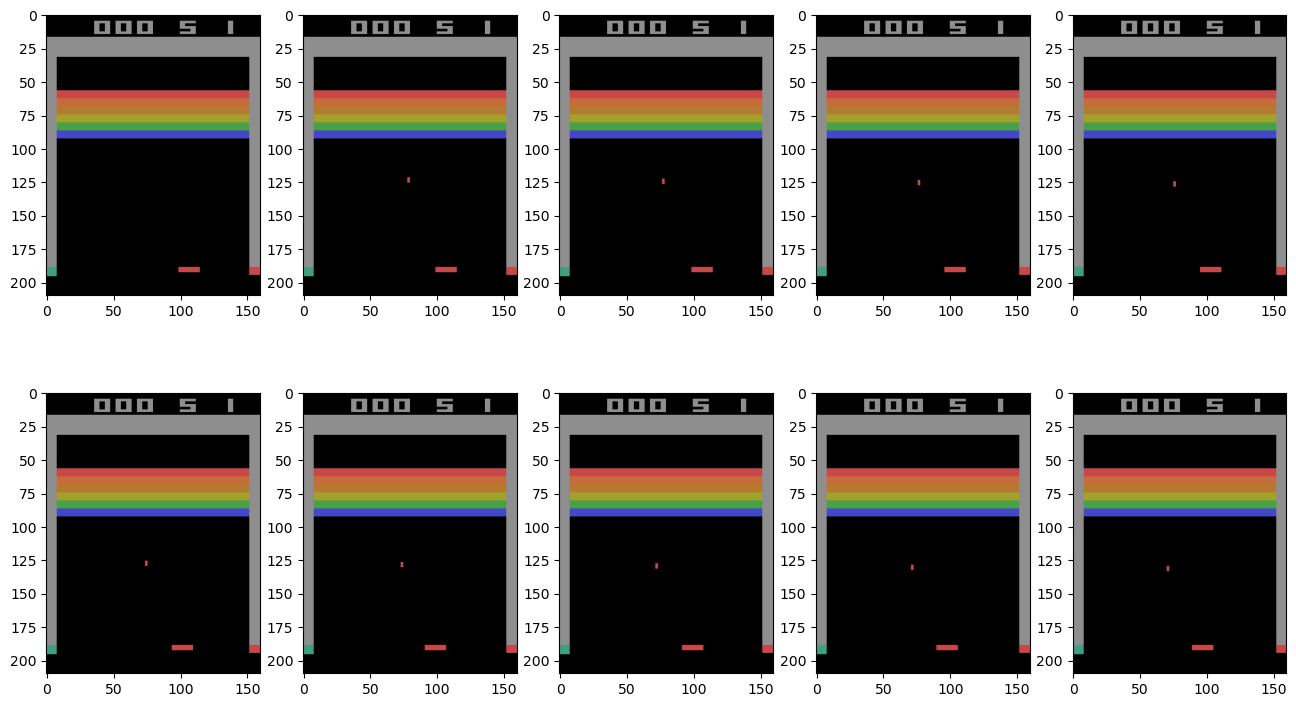

In [5]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

**Let's play a little.**

Pay attention to zoom and fps args of play function. Control: A, D, space.

In [6]:
import os
# os.environ["SDL_VIDEODRIVER"] = "dummy"

In [7]:
# This block is just for fun and work only on your local pc
# Make keyboard interrupt to continue

# from gymnasium.utils.play import play

# play(env=gym.make(ENV_NAME, render_mode="rgb_array"), zoom=4, fps=40)

### Processing game image

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

Also please keep one dimension for channel so that final shape would be 1 x 64 x 64.

Tip: You can implement your own grayscale converter and assign a huge weight to the red channel. This trick is not necessary but it will speed up learning.

In [8]:
import cv2
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        res = rgb @ channel_weights
        return res
    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type

        img_cropped = img[30:-10, 5:-5] 
        img_resized = cv2.resize(img_cropped, (64, 64))
        img_gray = self._to_gray_scale(img_resized)
        img_normalized = img_gray.astype(np.float32) / 255.0
        img_final = img_normalized.reshape(self.img_size)
        return img_final

Formal tests seem fine. Here's an example of what you'll get.


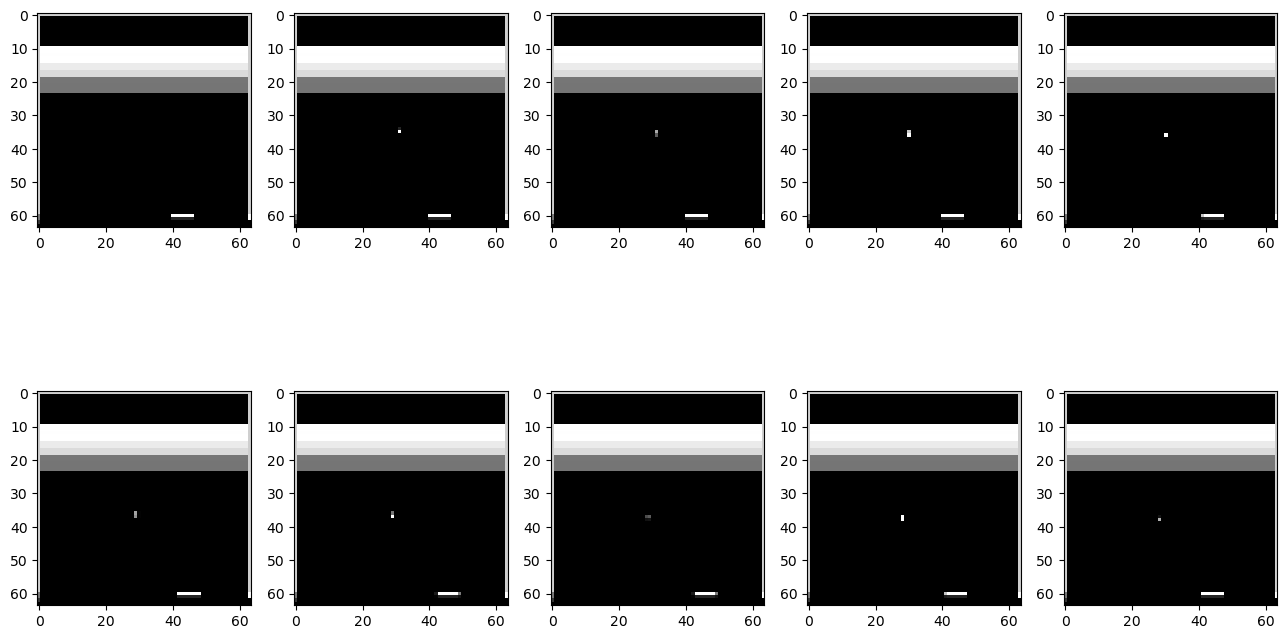

In [9]:
# spawn game instance for tests
env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"
assert np.max(obs) > 1. / 256, "you probably divided on 256 twice"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs, _ = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _, _ = env.step(env.action_space.sample())
plt.show()

# Wrapping

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

In [10]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

**Let's see if the game is still playable after applying the wrappers.**
At playing the EpisodicLifeEnv wrapper seems not to work but actually it does (because after when life finishes a new ball is dropped automatically - it means that FireResetEnv wrapper understands that a new episode began).

In [11]:
# does not work in colab.
# make keyboard interrupt to continue

# from gymnasium.utils.play import play

# def make_play_env():
#     env = gym.make(ENV_NAME, render_mode="rgb_array")
#     env = PrimaryAtariWrap(env)
# # in torch imgs have shape [c, h, w] instead of common [h, w, c]
#     env = atari_wrappers.AntiTorchWrapper(env)
#     return env

# play(make_play_env(), zoom=4, fps=3)

# Frame Buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity. To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [12]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(4, (4, 64, 64))

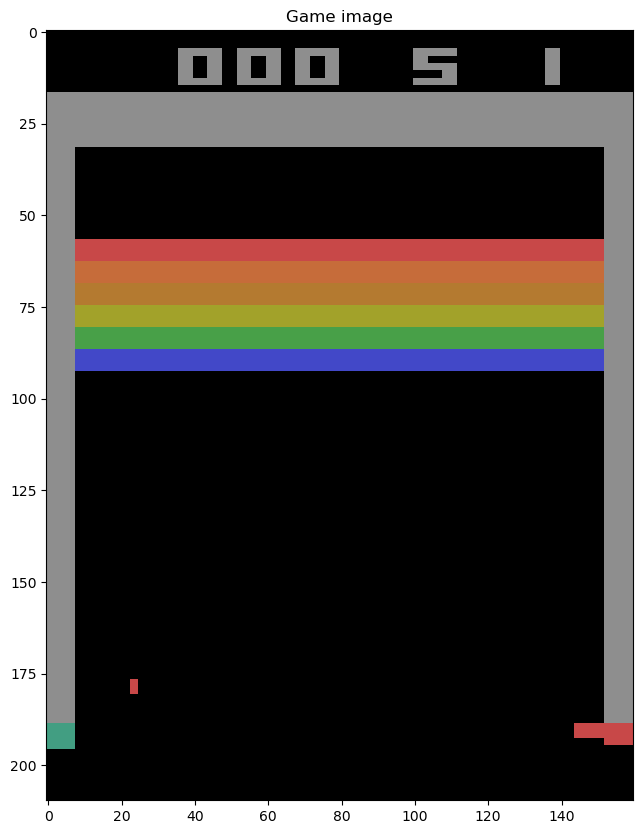

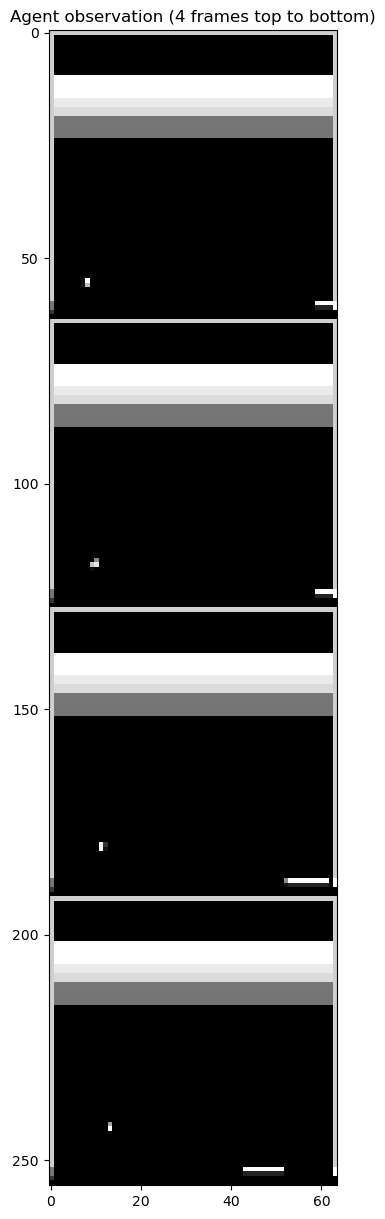

In [13]:
for _ in range(12):
    obs, _, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render())
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

# DQN as it is

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png width=640>

In [14]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [15]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [16]:
first = conv2d_size_out(16, 3, 2)
second = conv2d_size_out(first, 3, 2)
third = conv2d_size_out(second, 3, 2)
third

1

In [17]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Define your network body here. Please make sure agent is fully contained here
        self.net = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
        )
        
    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        batch_size, four, h, w = state_t.shape
        qvalues = self.classifier(self.net(state_t).view(batch_size, -1))
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(np.array(states), device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [18]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [19]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [20]:
evaluate(env, agent, n_games=1)

0.0

# Experience Replay
There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: Experience Replay. The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=640>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer.
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [21]:
from collections import deque 

class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._maxsize = size
        self._storage = deque([], maxlen=size)

        
    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        self._storage.append(data)


    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        sampled = random.choices(self._storage, k=batch_size)
        return map(lambda x: np.array(x, copy=False), zip(*sampled))

In [22]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(),
                   1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [23]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        s_new, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated 
        exp_replay.add(s, action, reward, s_new, done)
        s = s_new
        sum_rewards += reward
        if done:
            s, _ = env.reset()
    return sum_rewards, s

In [24]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


# Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$


<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png width=640>

In [25]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot \max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [26]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)
    # select q-values for chosen actions
    predicted_qvalues_for_actions = torch.gather(predicted_qvalues, 1, actions.view(-1, 1)).squeeze(-1)

    # compute V*(next_states) using predicted next q-values
    next_state_values = predicted_next_qvalues.max(1).values  # like here: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to ac|hieve this.
    target_qvalues_for_actions = next_state_values.detach() * gamma * is_not_done + rewards

    assert target_qvalues_for_actions.requires_grad == False, "do not send gradients to target!"

    # mean squared error loss to minimize
    loss = torch.mean(torch.square(target_qvalues_for_actions - predicted_qvalues_for_actions))

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [27]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

In [28]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

# Main loop

It's time to put everything together and see if it learns anything.

In [29]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [30]:
seed = sum(map(ord, list('МОПВСТОЙЛО')))
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [31]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [32]:
exp_replay = ReplayBuffer(10**5)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**3)
    if len(exp_replay) == 10**5:
        break
        break
print(len(exp_replay))

100000


In [33]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 1 * 10**6  # было 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4) 
scaler = torch.cuda.amp.GradScaler()

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [34]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 100000, epsilon = 0.10000


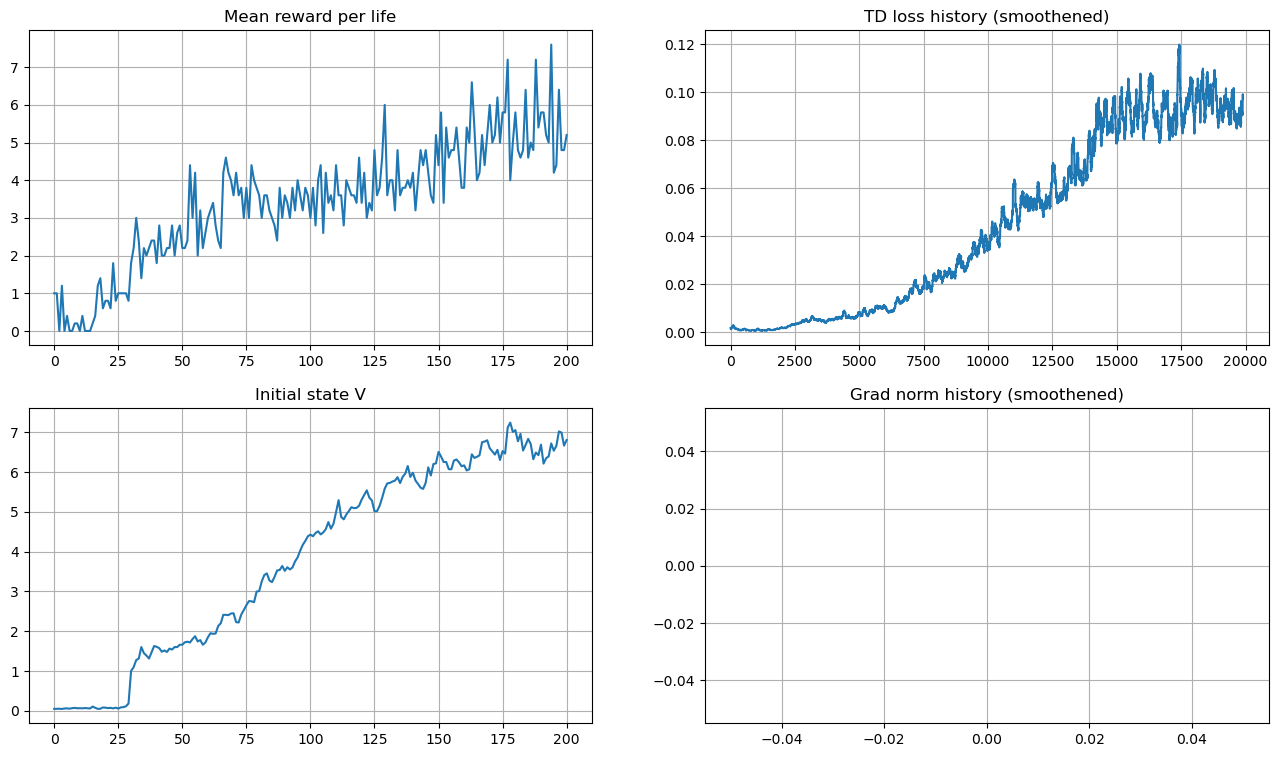

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000001/1000001 [1:58:56<00:00, 140.12it/s]


In [35]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
    
    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # sample batch_size of data from experience replay 
    states, actions, rewards, next_states, is_done = exp_replay.sample(batch_size)
    with torch.cuda.amp.autocast():
        loss = compute_td_loss(states, actions, rewards, next_states, is_done, agent, target_network)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    scaler.step(opt)
    scaler.update()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item() or 0)  # in case of NaN gradient and skipping step let grad norm be zero

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()

In [43]:
np.sum(grad_norm_history)

inf

Agent is evaluated for 1 life, not for a whole episode of 5 lives. Rewards in evaluation are also truncated. Cuz this is what environment the agent is learning in and in this way mean rewards per life can be compared with initial state value

**The goal is to get 15 points in the real env**. So 3 or better 4 points in the preprocessed one will probably be enough. You can interrupt learning then.

Final scoring is done on a whole episode with all 5 lives.

In [36]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 15, 'not as cool as DQN can'
print('Cool!')

final score: 41.0
Cool!


## How to interpret plots:

This aint no supervised learning so don't expect anything to improve monotonously.
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50) though it depends on network architecture.
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...).
 * In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Smoothing of plots is done with a gaussian kernel

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

**Training will take time.** A lot of it actually. Probably you will not see any improvment during first **150k** time steps (note that by default in this notebook agent is evaluated every 5000 time steps).

## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy that generated it. It can even happen that the mean TD error across the buffer is very low but the performance is extremely poor (imagine the agent collecting data to the buffer always manages to avoid the ball).

* Total timesteps and training time: It seems to be so huge, but actually it is normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and it can work not worse than Adam. For us Adam was default and it worked.

* lr: $10^{-3}$ would probably be too huge

* batch size: This one can be very important: if it is too small the agent can fail to learn. Huge batch takes more time to process. If batch of size 8 can not be processed on the hardware you use take 2 (or even 4) batches of size 4, divide the loss on them by 2 (or 4) and make optimization step after both backward() calls in torch.

* target network update frequency: has something in common with learning rate. Too frequent updates can lead to divergence. Too rare can lead to slow leraning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an iteration of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.
* max_grad_norm - just huge enough. In torch clip_grad_norm also evaluates the norm before clipping and it can be convenient for logging.

# Record a video

In [37]:
# record sessions
from gymnasium.wrappers import RecordVideo

with RecordVideo(env=make_env(), video_folder='./videos',
                 episode_trigger = lambda episode_number: True) as env_monitor:
    sessions = [evaluate(env_monitor, agent, n_games=n_lives,
                         greedy=True) for _ in range(10)]
env.close()

/home/vladimir/.local/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/vladimir/PycharmProjects/hw2/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/vladimir/.local/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/home/vladimir/.local/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-0.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-0.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-1.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-1.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-1.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-2.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-2.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-2.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-3.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-3.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-3.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-4.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-4.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-4.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-5.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-5.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-5.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-6.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-6.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-6.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-7.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-7.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-7.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-8.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-8.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-8.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-9.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-9.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-9.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-10.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-10.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-10.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-11.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-11.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-11.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-12.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-12.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-12.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-13.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-13.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-13.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-14.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-14.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-14.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-15.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-15.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-15.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-16.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-16.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-16.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-17.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-17.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-17.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-18.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-18.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-18.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-19.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-19.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-19.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-20.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-20.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-20.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-21.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-21.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-21.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-22.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-22.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-22.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-23.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-23.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-23.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-24.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-24.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-24.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-25.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-25.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-25.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-26.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-26.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-26.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-27.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-27.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-27.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-28.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-28.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-28.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-29.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-29.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-29.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-30.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-30.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-30.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-31.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-31.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-31.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-32.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-32.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-32.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-33.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-33.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-33.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-34.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-34.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-34.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-35.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-35.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-35.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-36.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-36.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-36.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-37.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-37.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-37.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-38.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-38.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-38.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-39.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-39.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-39.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-40.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-40.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-40.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-41.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-41.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-41.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-42.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-42.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-42.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-43.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-43.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-43.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-44.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-44.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-44.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-45.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-45.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-45.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-46.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-46.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-46.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-47.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-47.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-47.mp4
MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-48.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-48.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-48.mp4


MoviePy - Building video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-49.mp4.
MoviePy - Writing video /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-49.mp4



MoviePy - Done !
MoviePy - video ready /home/vladimir/PycharmProjects/hw2/videos/rl-video-episode-49.mp4


In [38]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[0]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Let's have a closer look at this (up to 1 point)

If average episode score is below 200 using all 5 lives, then probably DQN has not converged fully. But anyway let's make a more complete record of an episode.

In [39]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

total reward for life: 26.0
states
v_mc
v_agent
q_spreads
td_errors
rewards
episode_finished


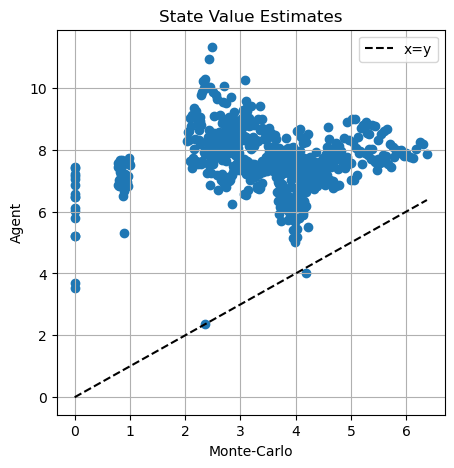

In [40]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()

$\hat V_{Monte-Carlo}(s_t) = \sum_{\tau=0}^{episode~end} \gamma^{\tau-t}r_t$

Is there a big bias? It's ok, anyway it works.

**1.** Plot several (say 3) states with high and low spreads of Q estimate by actions i.e.
$$\max_a \hat Q(s,a) - \min_a \hat Q(s,a)\$$
Please take those states from different episodes to make sure that the states are really different.

What should high and low spread mean at least in the world of perfect Q-fucntions?

Comment the states you like most.

**2.** Plot several (say 3) states with high td-error and several states with high values of
$$| \hat V_{Monte-Carlo}(s) - \hat V_{agent}(s)|,$$
$$\hat V_{agent}(s) = \max_a \hat Q(s,a).$$

Please take those states from different episodes to make sure that the states are really different. From what part (i.e. beginning, middle, end) of an episode did these states come from?

Comment the states you like most.

### Комментарий 1.

Мне нравятся все фрагменты с максимальным разбросом: они показывают, что очень важно в этом состоянии двинуться в правильном направлении, иначе цена ошибки очень высокая. Там, где разброс небольшой, модели без разницы особо, куда двигаться в конкретный момент, и от того или иного действия принципиально ничего в награде агента не изменится. 

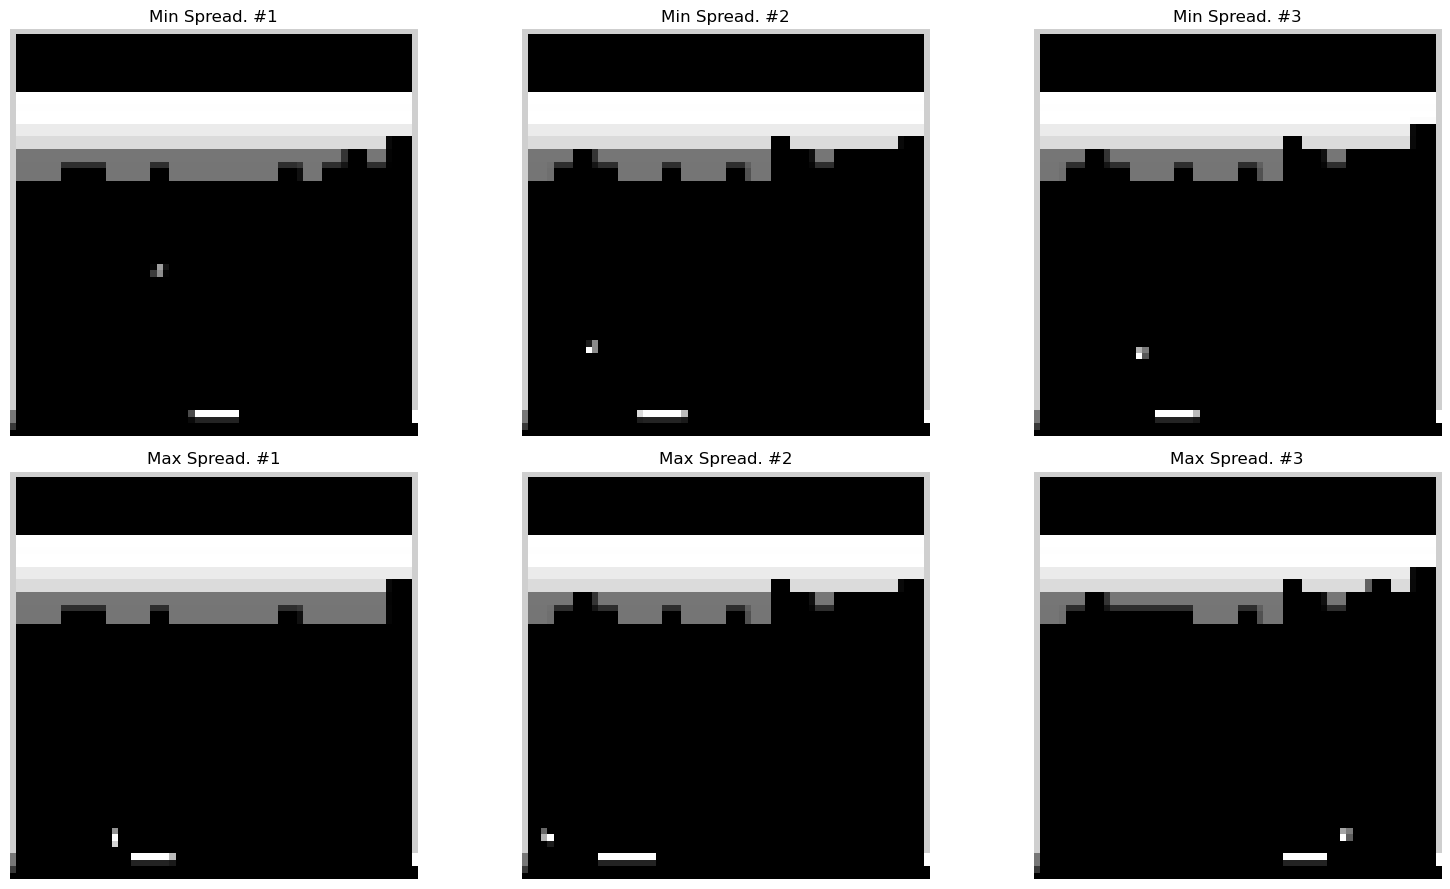

In [76]:
from utils import play_and_log_episode, img_by_obs

fig, axs = plt.subplots(2, 3, figsize=(16, 9))

for i in range(3):
    run = play_and_log_episode(env, agent)
    argmax = run['q_spreads'].argmax()
    argmin = run['q_spreads'].argmin()
    min_state = run['states'][argmin][0]
    max_state = run['states'][argmax][0]

    axs[0, i].imshow(min_state, cmap='gray')
    axs[0, i].set_title(f'Min Spread. #{i+1}')
    axs[0, i].axis('off')  

    axs[1, i].imshow(max_state, cmap='gray') 
    axs[1, i].set_title(f'Max Spread. #{i+1}')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

### Комментарий 2.

Похоже, большинство этих стейтов примерно с середины игры. Кажется, большинство из них - перед падением шарика на платформу. Причем разница между кадрами говорит о том, что из состояния, когда без разницы как действовать, мы перешли в состояние, где надо действовать правильно.

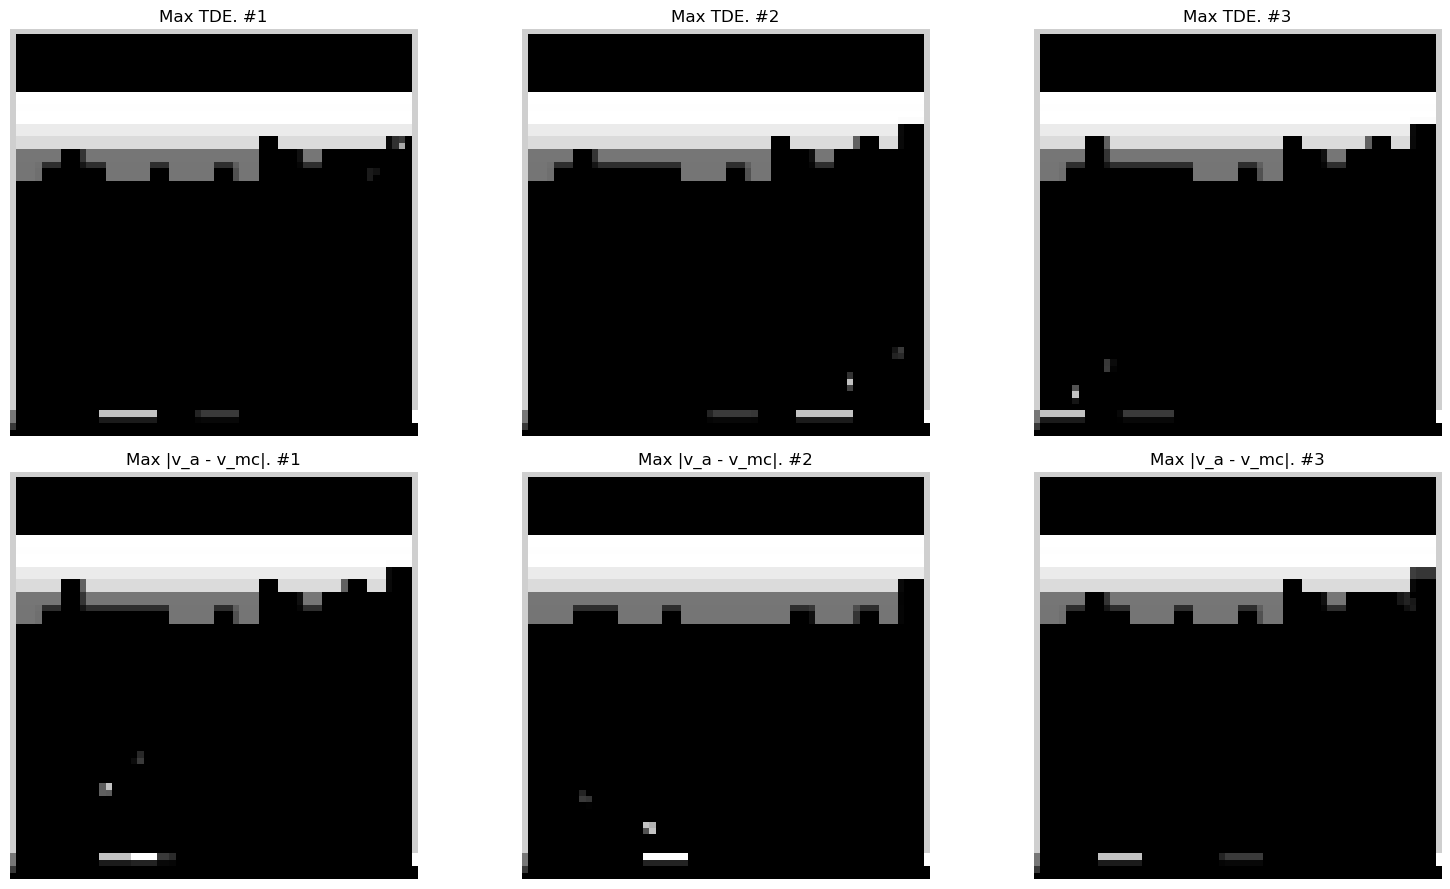

In [123]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))

for i in range(3):
    run = play_and_log_episode(env, agent)
    argmax = run['td_errors'].argmax()
    max_state = run['states'][argmax][0] + run['states'][argmax][-1] * 0.3

    axs[0, i].imshow(max_state, cmap='gray') 
    axs[0, i].set_title(f'Max TDE. #{i+1}')
    axs[0, i].axis('off')

for i in range(3):
    run = play_and_log_episode(env, agent)
    argmax = np.abs(run['v_agent'] - run['v_mc']).argmax()
    max_state = run['states'][argmax][0] + run['states'][argmax][-1] * 0.3

    axs[1, i].imshow(max_state, cmap='gray') 
    axs[1, i].set_title(f'Max |v_a - v_mc|. #{i+1}')
    axs[1, i].axis('off')
plt.tight_layout()
plt.show()

# Bonus area
# Apply modifications to DQN

For inspiration see [Rainbow](https://arxiv.org/abs/1710.02298) - a version of q-learning that combines lots of them.

* [Quantile regression q-learning](https://arxiv.org/abs/1710.10044) (1 pt)
* [Prioritized experience replay](https://arxiv.org/abs/1511.05952) (0.5 pts, use prioritized_sampler.py for template; +2 pts for bias correction)
* [Double q-learning](https://arxiv.org/abs/1509.06461) (0.5 pt)
* [Dueling q-learning](https://arxiv.org/abs/1511.06581) (0.5 pt)
* [Noisy networks](https://arxiv.org/abs/1706.10295) (0.75 pts)
* Multi-step heuristics (see [Rainbow](https://arxiv.org/abs/1710.02298)) (1 pts)
* Something else? (depending on complexity)

In [77]:
# You can use this implementation of SumTree structure by MorvanZhou
# to make sampling O(log n)
class SumTree():
    """
    Stores the priorities in sum-tree structure for effecient sampling.
    Tree structure and array storage:
    Tree index:
         0         -> storing priority sum
        / \
      1     2
     / \   / \
    3   4 5   6    -> storing priority for transitions
    Array type for storing:
    [0,1,2,3,4,5,6]
    """

    def __init__(self, capacity):
        self.capacity = capacity  # for all priority values
        self.tree = np.zeros(2 * capacity - 1)
        # [--------------parent nodes-------------][-------leaves to record priority-------]
        #             size: capacity - 1                       size: capacity
    
    def update(self, idx, p):
        """
        input: idx - int, id of leaf to update
        input: p - float, new priority value
        """
        assert idx < self.capacity, "SumTree overflow"

        idx += self.capacity - 1  # going to leaf №i

        change = p - self.tree[idx]
        self.tree[idx] = p
        while idx != 0:    # faster than the recursive loop
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get_leaf(self, v):
        """
        input: v - float, cumulative priority of first i leafs
        output: i - int, selected index
        """
        parent_idx = 0
        while True:
            cl_idx = 2 * parent_idx + 1         # this leaf's left and right kids
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):        # reach bottom, end search
                leaf_idx = parent_idx
                break
            else:       # downward search, always search for a higher priority node
                if v <= self.tree[cl_idx] or self.tree[cr_idx] == 0.0:
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        return leaf_idx - (self.capacity - 1)

    def __getitem__(self, indices):
        res = []
        for idx in indices: 
            new_idx = idx + self.capacity - 1
            res.append(self.tree[new_idx])
        return res

    @property
    def total_p(self):
        return self.tree[0]  # the root is sum of all priorities

In [98]:
class PrioritizedSampler:
    def __init__(self, size, clip_priorities=1.0, rp_alpha=0.4, beta=0.1):
        """
        Parameters
        ----------
        size: int
            Max number of prirotieis to store (same as your replay buffer size). 
        clip_priorities: float
            All priorities higher than this will be clipped. You can experiment with this...
        rp_alpha: float
            p**rp_alpha is used as sampling probability, where p is priority
        beta: float 
            Number for bias correction according to paper
        """
        self.clip_priorities = clip_priorities
        self.rp_alpha = rp_alpha
        self.priorities = SumTree(size)
        self.beta = 1 
        self.max_priority = 1.0
        self.storage = deque([None] * size, size)
        self.counter = 0
        self.size = size
    
    def add(self, *args):
        self.storage[self.counter] = args
        self.priorities.update(self.counter, self.max_priority)
        self.counter = (self.counter + 1) % self.size
    
    def sample(self, indicies): 
        sampled = [self.storage[x] for x in indicies]
        return map(lambda x: np.array(x, copy=False), zip(*sampled))
    
    def sample_indices(self, batch_size):
        '''
        Samples indices using priorities
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        indices: np.array
            batch of indices to sample from replay buffer
        weights: np.array
            batch of importance sampling weights
        """
        '''
        s = self.priorities.total_p / batch_size
        indices = [
            self.priorities.get_leaf(
                random.uniform(s * i,  s * (i + 1))
            )
            for i in range(batch_size)
        ]
        probabilities = self.priorities[indices] / self.priorities.total_p
        weights = (len(self) * probabilities) ** -self.beta
        weights = weights / weights.max()
        return indices, weights
    
    def __len__(self): 
        if None in self.storage: 
            return self.storage.index(None)
        return len(self.storage)
    
    def update_priorities(self, indices, new_priorities):
        '''
        Updates priorities with new_priorities on given indices.
        Parameters
        ----------
        indices: np.array
            indices to update
        new_priorities: np.array
            new priorities to set
        '''
        new_priorities = (new_priorities**self.rp_alpha).clip(min=1e-5, max=self.clip_priorities)
        for idx, priority in zip(indices, new_priorities):
            self.priorities.update(idx, priority)
        self.max_priority = max(self.max_priority, new_priorities.max())

In [108]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [114]:
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
timesteps_per_epoch = 1
batch_size = 32
total_steps = 1 * 10**6  # было 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4) 
scaler = torch.cuda.amp.GradScaler()

init_epsilon = 1
final_epsilon = 0.1

init_beta = 0.1
final_beta = 1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

In [115]:
exp_replay = PrioritizedSampler(10**5, beta=init_beta)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**3)
    if len(exp_replay) == 10**5:
        break
print(len(exp_replay))

100000


In [116]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device, weights=1):
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    weights = torch.tensor(weights, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )
    is_not_done = 1 - is_done
    predicted_qvalues = agent(states)
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)
    predicted_qvalues_for_actions = torch.gather(predicted_qvalues, 1, actions.view(-1, 1)).squeeze(-1)
    next_state_values = predicted_next_qvalues.max(1).values 
    target_qvalues_for_actions = next_state_values.detach() * gamma * is_not_done + rewards
    error = target_qvalues_for_actions - predicted_qvalues_for_actions
    loss = torch.mean(error ** 2 * weights)
    return loss, error.abs().detach()

buffer size = 100000, epsilon = 0.89650, beta = 0.20350


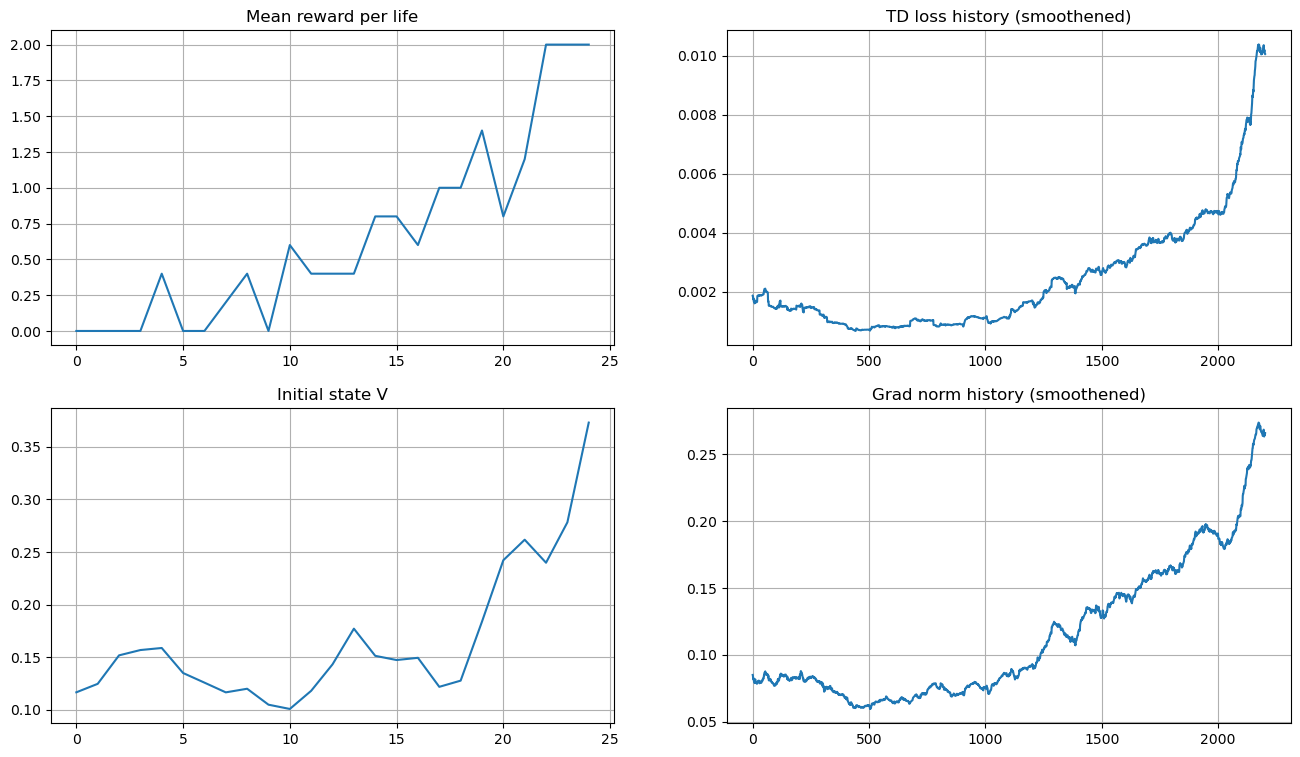

 12%|██████████████▏                                                                                                        | 118783/1000001 [14:38<1:39:14, 147.98it/s]

In [ ]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass
    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
    exp_replay.beta = utils.linear_decay(init_beta, final_beta, step, decay_steps)
    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)
    # train
    # sample batch_size of data from experience replay 
    indicies, weights = exp_replay.sample_indices(batch_size)
    states, actions, rewards, next_states, is_done = exp_replay.sample(indicies)
    with torch.cuda.amp.autocast():
        loss, td_error = compute_td_loss(states,
                                         actions,
                                         rewards,
                                         next_states,
                                         is_done,
                                         agent,
                                         target_network,
                                         weights=weights)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    scaler.step(opt)
    scaler.update()
    opt.zero_grad()
    
    # update transition priority
    exp_replay.update_priorities(indicies, td_error.cpu().numpy())
    
    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item() or 0)  # in case of NaN gradient and skipping step let grad norm be zero

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f, beta = %.5f" %
              (len(exp_replay), agent.epsilon,exp_replay.beta))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()